<a href="https://colab.research.google.com/github/Kajlid/Final-project-Machine_Learning/blob/Magda/Project_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# LIBRARIES #
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import io
import sklearn
import sklearn.metrics  as metrics
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

In [ ]:
# READ CSV #
warnings.filterwarnings('ignore')
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['student-por.csv'])) 

In [37]:
# FIRST APPROACH TO THE DATASET #

# columns names #
data_names = ['school', 'sex', 'age', 'address', 'family_size', 'parent_cohabition_status', 'mother_education', 'father_education','mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'school_support', 'family_support', 'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences','grade_period1', 'grade_period2', 'final_grade' ]
data.columns = data_names

# numerical vs categorical columns #
numerical_columns = ['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences','grade_period1', 'grade_period2', 'final_grade']
categorical_columns = ["school","sex",'address', 'family_size', 'parent_cohabition_status','mother_job', 'father_job', 'reason', 'guardian',"school_support", "family_support",'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic']


In [ ]:
# CLEAN THE DATABASE # 

# 1. Drop the columns that we are not going to use.
data_clean = data.drop(['grade_period1', 'grade_period2'], axis=1)

# 2. Drop na's.
data_clean=data.replace(r'^\s*$', np.nan, regex=True)
data_clean=data_clean.dropna(inplace=True)

# 3. Get the dummies so that it is easier to work. 
# This is, transform the categorical columns into numerical ones. 
data_clean = pd.get_dummies(data, columns=categorical_columns)
data_clean.describe()

# 4. Transform the data. 
# we need to standarize the data to take into consideration variations in measurments, units and scales. 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_clean[numerical_columns])
scaled_dataframe = pd.DataFrame(scaled_data, columns = numerical_columns)  
print(scaled_dataframe.columns)
scaled_dataframe.head()

for column in numerical_columns:
  data_clean.append(scaled_dataframe[column])
  data_clean[column] = scaled_dataframe[column]

data_clean.columns

In [ ]:
# SCATTER PLOT MATRIX #
# A scatter plot matrix is a grid  of scatter plots used to visualize relationships between combinations of variables. 
# Each scatter plot in the matrix visualizes the relationship between a pair of variables, allowing many relationships to be explored in one chart.

bm = data_clean.columns.isin(["father_education","mother_education","failures","studytime"])
sc = data_clean.columns[bm]
df=data_clean[sc]

pd.plotting.scatter_matrix(frame= df, alpha=0.5, figsize=(10,10), 
                            marker='o', hist_kwds={'bins': 30}, s=20,
                           range_padding=0.05, cmap=plt.cm.brg,color="g")
plt.show()


In [ ]:
# CORRELATION MATRIX #
# this is the correlation matrix of the whole cleaned dataset. 

corr = data_clean.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [ ]:
# CORRELATION MATRIX WITH LESS VARIABLES # 
# FUNCTION #

# 1. create the function 
def corr_matrix(chosen_columns):
  bm = data_clean.columns.isin(chosen_columns)
  sc = data_clean.columns[bm]
  df=data_clean[sc]
  corr = df.corr()
  return(corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2))

# 2.choose the variables in which we want to see the correlation
chosen = ["sex_M","sex_F","grade_period1","failures","absences", "final_grade"]

# 3. call the function 
corr_matrix(chosen)

In [ ]:
# EIGENVECTORS AND EIGENVALUES #

# 1. Get the covariance matrix
cov = data_clean.cov()

# 2. Computes the eigenvalue and eigenvector of the square.
# The eigenvectors are the directions in which the data varies the most --> L
# The eigenvalues represent the magnitude of the variance in those directions -->  Q
L,Q = np.linalg.eig(cov)

# 3. Plotting the eigenvalues. 
# The plot will show the importance of each principal component in terms of
# the amount of variance it captures. The first principal component will have the 
# largest eigenvalue, followed by the second, and so on. The plot can help you decide 
# how many principal components to retain based on a certain amount of variance explained, 
# or it can be used to visualize the structure of the data in a lower-dimensional space.

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(L)),L)
plt.xticks(ticks = range(len(L)))
plt.ylabel('Eigenvalue')
plt.xlabel('Principal direction')
plt.xlim((1, len(L)-1))
plt.xticks(range(0,60,4))

plt.ylim((0,2.5))
ax.grid()
plt.show()

# 4. Plotting eigenvectors. 
# Now, we'll proceed to plot the 2 eigenvectors in Q having the largest eigenvalues. 
# The plot can be useful for visualizing the structure of the data in a lower-dimensional 
# space and for identifying any patterns or clusters in the data.

print("\n")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(L)),Q[:,0:2])
plt.xticks(ticks = range(len(L)), labels=data_clean.columns,rotation=80, fontsize=8)
ax.legend(labels=['PD1','PD2'])
plt.ylabel('Value')
plt.xlim((1, len(L)-1))
plt.ylim((-0.5,0.5))
plt.title("Eigenvectors")
ax.grid()
plt.show()

In [42]:
# PCA #

# Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. 
# These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most 
# of the information within the initial variables is squeezed or compressed into the first components. 
# So, the idea is 10-dimensional data gives you 10 principal components, but PCA tries to put maximum possible information 
# in the first component, then maximum remaining information in the second and so on. 

# Organizing information in principal components this way, will allow us to reduce dimensionality without losing much information.
# An important thing to realize here is that the principal components are less interpretable and don’t have any real meaning 
# since they are constructed as linear combinations of the initial variables.

# How to Select the Best Number of Principal Components for the Dataset?
# 1. Scree plot method. 
# 2. Cumulative explained variance
# 3. Cross validation

In [ ]:
# PCA #
# Method 1: Scree plot method
# this one takes the same criteria as the elbow plot. 

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(L)),L)
plt.xticks(ticks = range(len(L)))
plt.ylabel('Eigenvalue')
plt.xlabel('Principal direction')
plt.xlim((1, len(L)-1))
plt.xticks(range(0,60,4))

plt.ylim((0,2.5))
ax.grid()
plt.show()

In [ ]:
# PCA #
# Method 2: Cumulative explained variance. 
# Usually, one seeks to have an explained variance between 0.6 and 0.8. 

pca = PCA().fit(data_clean)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.xticks(range(0,60,4))
plt.grid()

In [69]:
# PCA #
# Method 3: Cross validation

# 1. Select the input and the target data. 
# Input data: matrix of features or attributes that describe the samples in your dataset.
# Target data: vector of labels or outcomes that you want to predict. 
bm = data_clean.columns.isin(['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_period1', 'grade_period2', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'family_size_GT3', 'family_size_LE3', 'parent_cohabition_status_A', 'parent_cohabition_status_T', 'mother_job_at_home', 'mother_job_health',
       'mother_job_other', 'mother_job_services', 'mother_job_teacher', 'father_job_at_home', 'father_job_health', 'father_job_other','father_job_services', 
       'father_job_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 
       'school_support_yes','family_support_yes', 'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes', 'higher_yes', 'internet_access_yes','romantic_yes'])
sc = data_clean.columns[bm]
input=data_clean[sc]

bm = data_clean.columns.isin(["final_grade"])
s = data_clean.columns[bm]
target=data_clean[s]

# 2. Select the number of folds.
# The data will be split into 10 equal parts, and the model will be trained and 
# evaluated 10 times. 
folds = 10

# 3. Evaluate the linear regression model using cross validation. 

# Linear regression is a supervised machine learning algorithm used for predicting a 
# continuous target variable based on one or more input features that have a linear
# relationship with the target variable.

# The linear regression model assumes that the relationship between the input 
# features and the target variable can be modeled using a linear function, which 
# is a straight line in the case of a single input feature or a plane in the case of multiple input features.

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
model = LinearRegression()
scores = cross_val_score(model, input, target, cv=kf)

# 4. Print the cross-validation scores
print("Validation scores:")
l=len(scores)
for i in range(l):
  print(i+1,":",scores[i])

# 5. Average score
# The results of the cross validation are averaged across the k 
# folds to produce an overall estimate of the model's performance.
# The average score represents the average performance of the ML model across all folds of the cross-validation.
print("\n")
print("Average score:", np.mean(scores))
print("Standard deviation:", np.std(scores))


Validation scores:
1 : 0.9169962093158238
2 : 0.7876453421824321
3 : 0.9037035430698711
4 : 0.7480769726059067
5 : 0.7814969368108162
6 : 0.7680183075328676
7 : 0.8496946502725672
8 : 0.8790695878529428
9 : 0.8016515891461354
10 : 0.9173360796958399


Average score: 0.8353689218485203
Standard deviation: 0.062160118396198824
LinearRegression()


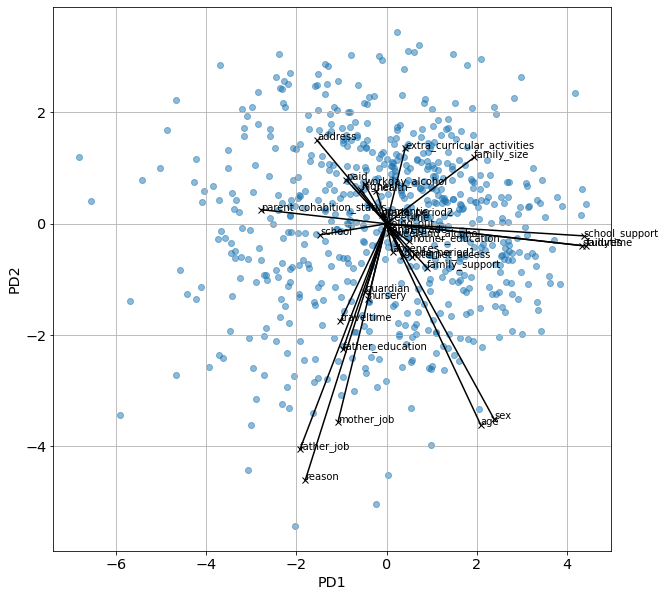

In [77]:
X = data_clean.to_numpy()

Xproj = np.dot(Q[:,(0,1)].T,(X-X.mean(axis=0)).T).T

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)

hand = ax.scatter(Xproj[:,0],Xproj[:,1],alpha=0.5)

# add the standard basis
for dim in range(len(data.columns)):
  ax.plot((0,10*Q[dim,0]),(0,10*Q[dim,1]),c='black')
  ax.text(10*Q[dim,0],10*Q[dim,1],data.columns[dim],fontsize=10)
  ax.plot(10*Q[dim,0],10*Q[dim,1],marker='x',c='black')

plt.xlabel('PD1')
plt.ylabel('PD2')
ax.grid()
plt.show()